# BB-EIT: Prediction with 5-Fold CV

Dataset: Proteins_Data_Augmented_Heteroscedastic.csv

Extended Features: Thickness, CA, ZP, pI, MW

Scaling: None

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import umap
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.colors import Normalize

c:\Users\shiws\miniforge3\envs\rdkit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CHEMBERT_MODEL = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(CHEMBERT_MODEL)
chembert = AutoModel.from_pretrained(CHEMBERT_MODEL)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
chembert.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(767, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [3]:
class PolymerDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.smiles = dataframe["SMILES"].values
        self.features = dataframe[["Protein Charge (pI)", "Thickness (nm)", "Predicted CA (deg)", "Predicted Zeta (mV)", "Protein MW / kDa"]].values
        self.amount = dataframe["Protein adsorption / ng cm-2"].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.smiles[idx], return_tensors="pt", padding="max_length",
                                  truncation=True, max_length=128)
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        protein_features = torch.tensor(self.features[idx], dtype=torch.float32)
        amount = torch.tensor(self.amount[idx], dtype=torch.float32)
        return input_ids, attention_mask, protein_features, amount

In [4]:
class ChemBERTRegressor(nn.Module):
    def __init__(self, chembert, num_features=5, hidden_dim=256):
        super(ChemBERTRegressor, self).__init__()
        self.chembert = chembert
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(768 + num_features, self.hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_dim, 1)

    def forward(self, input_ids, attention_mask, protein_features, extract_layer='output'):
        with torch.no_grad():
            outputs = self.chembert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]  
        
        holistic_feature_vector = torch.cat((pooled_output, protein_features), dim=1)
        
        if extract_layer == 'concatenate':
            return holistic_feature_vector.detach() 

        fc1_output = self.relu(self.fc1(holistic_feature_vector))
        
        if extract_layer == 'fc1':
            return fc1_output.detach() 

        return self.fc2(fc1_output).squeeze()

def extract_fc1_features(model, data_loader):
    model.eval()
    features_list = []

    for input_ids, attention_mask, physical_features, _ in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        physical_features = physical_features.to(device)
        features = model(input_ids, attention_mask, physical_features, extract_layer='fc1')
        features_list.append(features.cpu().numpy())
            
    return np.concatenate(features_list, axis=0)


In [5]:
protein_data = pd.read_csv("Proteins_Data_Augmented_Heteroscedastic.csv")
full_df = protein_data.copy()

In [6]:
full_dataset = PolymerDataset(full_df, tokenizer)
full_dataloader = DataLoader(full_dataset, batch_size=32, shuffle=False)

In [7]:
loaded_models = []
for i in range(5):
    model = ChemBERTRegressor(chembert)
    model.load_state_dict(torch.load(f"R2D2_All_All_fold_{i}.pth", map_location=device))
    model.to(device)
    model.eval()
    loaded_models.append(model)
models = loaded_models

In [8]:
all_fc1_features_ensemble = []
for model in models:
    fc1_features_fold = extract_fc1_features(model, full_dataloader)
    all_fc1_features_ensemble.append(fc1_features_fold)

In [9]:
fc1_features = np.mean(all_fc1_features_ensemble, axis=0)

In [10]:
fc1_scaler = StandardScaler()
scaled_fc1_features = fc1_scaler.fit_transform(fc1_features)

In [11]:
def perform_umap_analysis(features_data, n_neighbors=15, min_dist=0.1, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    return umap_model.fit_transform(features_data)


In [15]:
umap_params = {'n_neighbors': 15, 'min_dist': 0.5}
fc1_umap_projection = perform_umap_analysis(scaled_fc1_features, **umap_params)

c:\Users\shiws\miniforge3\envs\rdkit\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\shiws\miniforge3\envs\rdkit\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [16]:
full_df['UMAP_FC1_X'] = fc1_umap_projection[:, 0]
full_df['UMAP_FC1_Y'] = fc1_umap_projection[:, 1]


def get_protein_label(pi_value):
    if pi_value == 4.7:
        return 'BSA'
    elif pi_value == 11.0:
        return 'Lys'
    elif pi_value == 5.8:
        return 'Fib'
    else:
        return f'Others'

full_df['Protein Label'] = full_df['Protein Charge (pI)'].apply(get_protein_label)
full_df['Protein Adsorption (ng/cm\u00b2)'] = full_df['Protein adsorption / ng cm-2']

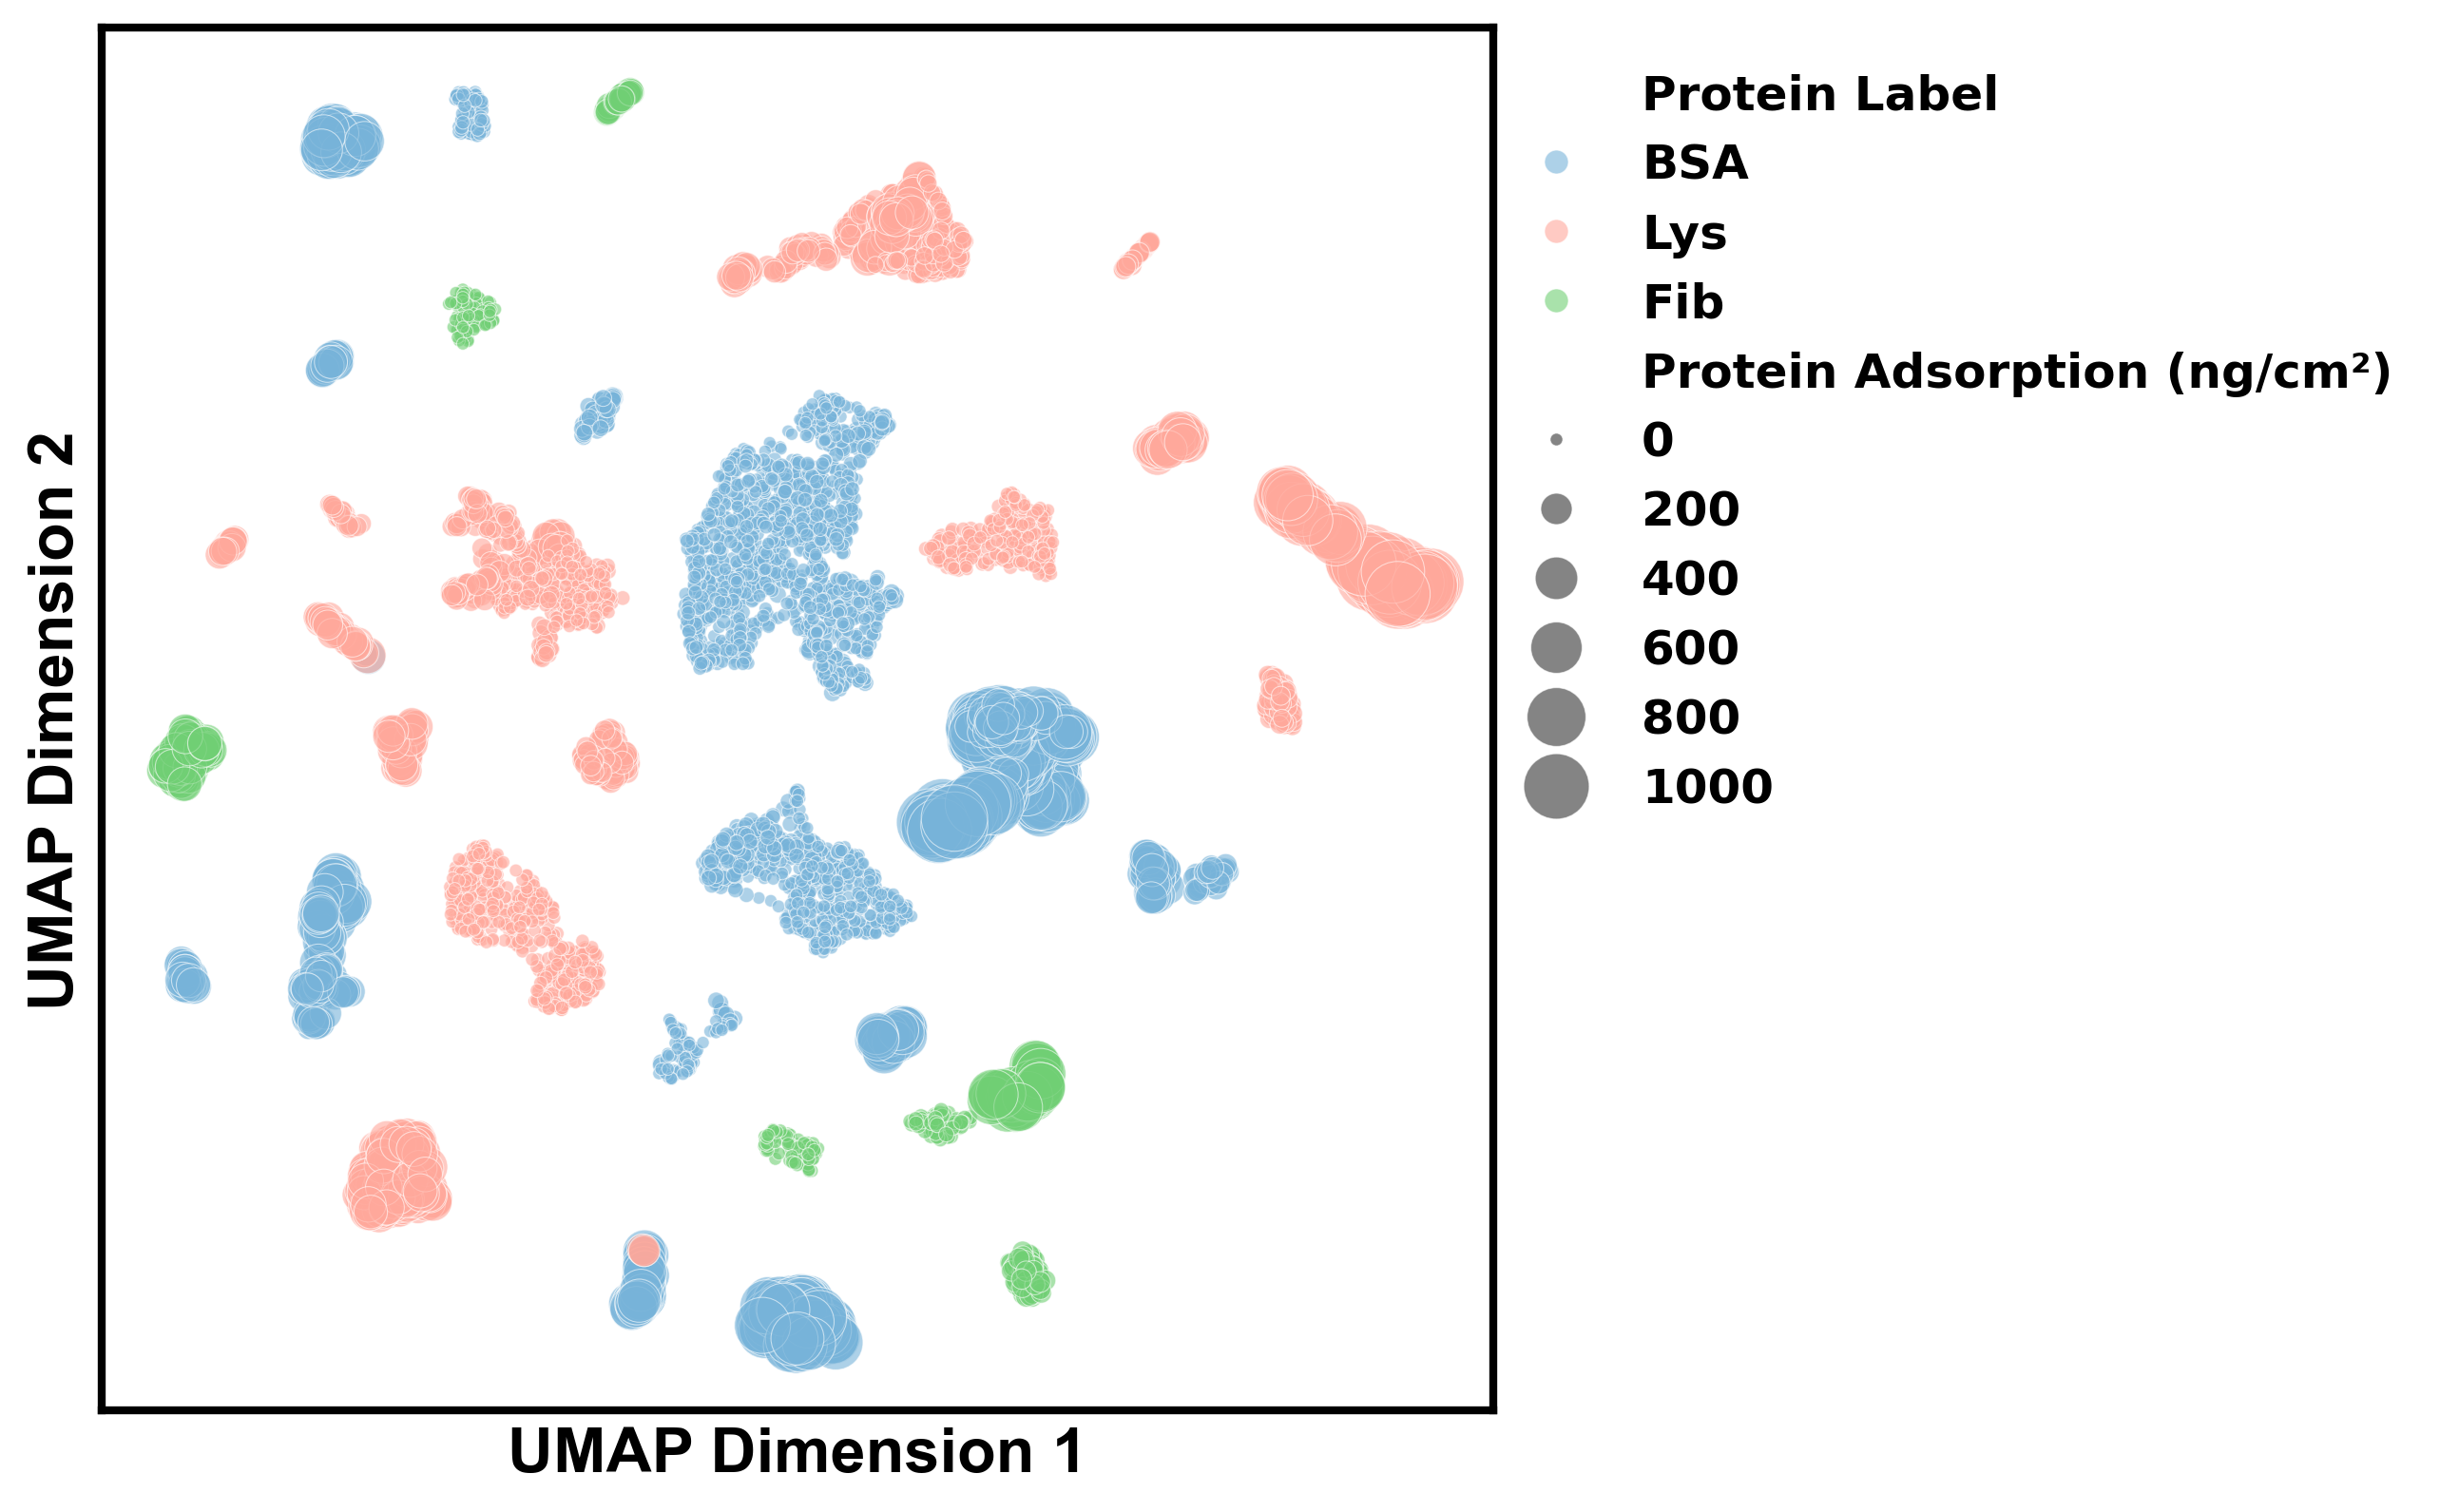

In [17]:
plt.figure(figsize=(6.3, 6.3), dpi=300)

protein_colors = {'BSA': "#77B3D9",
                  'Lys': "#ffa89b",
                  'Fib': "#70CF74"
}

sns.scatterplot(
    x='UMAP_FC1_X', 
    y='UMAP_FC1_Y', 
    hue=full_df['Protein Label'],
    size='Protein Adsorption (ng/cm\u00b2)',
    sizes=(10, 300),
    alpha=0.6,
    palette=protein_colors, 
    data=full_df,
)

plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2) 
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.xticks([])
plt.yticks([])

plt.xlabel('UMAP Dimension 1', fontsize=16, fontweight='bold', font='Arial')
plt.ylabel('UMAP Dimension 2', fontsize=16, fontweight='bold', font='Arial')

plt.legend(loc='center left', bbox_to_anchor=(0.98, 0.7), prop={'size': 12, 'weight': 'bold'}, ncol=1, frameon=False)

plt.show()

In [17]:
full_df['Zeta Potential'] = full_df['Predicted Zeta (mV)']
full_df['Contact Angle'] = full_df['Predicted CA (deg)']
full_df['Film Thickness'] = full_df['Thickness (nm)']
full_df['Protein Size'] = full_df['Protein MW / kDa']
full_df['Protein Charge'] = full_df['Protein Charge (pI)']

feature_columns = [
    "Contact Angle",
    "Zeta Potential",
    "Film Thickness", 
    "Protein Charge", 
    "Protein Size",
    #"Protein adsorption / ng cm-2"
]


umap_x = 'UMAP_FC1_X'
umap_y = 'UMAP_FC1_Y'
size_col = 'Protein adsorption / ng cm-2'



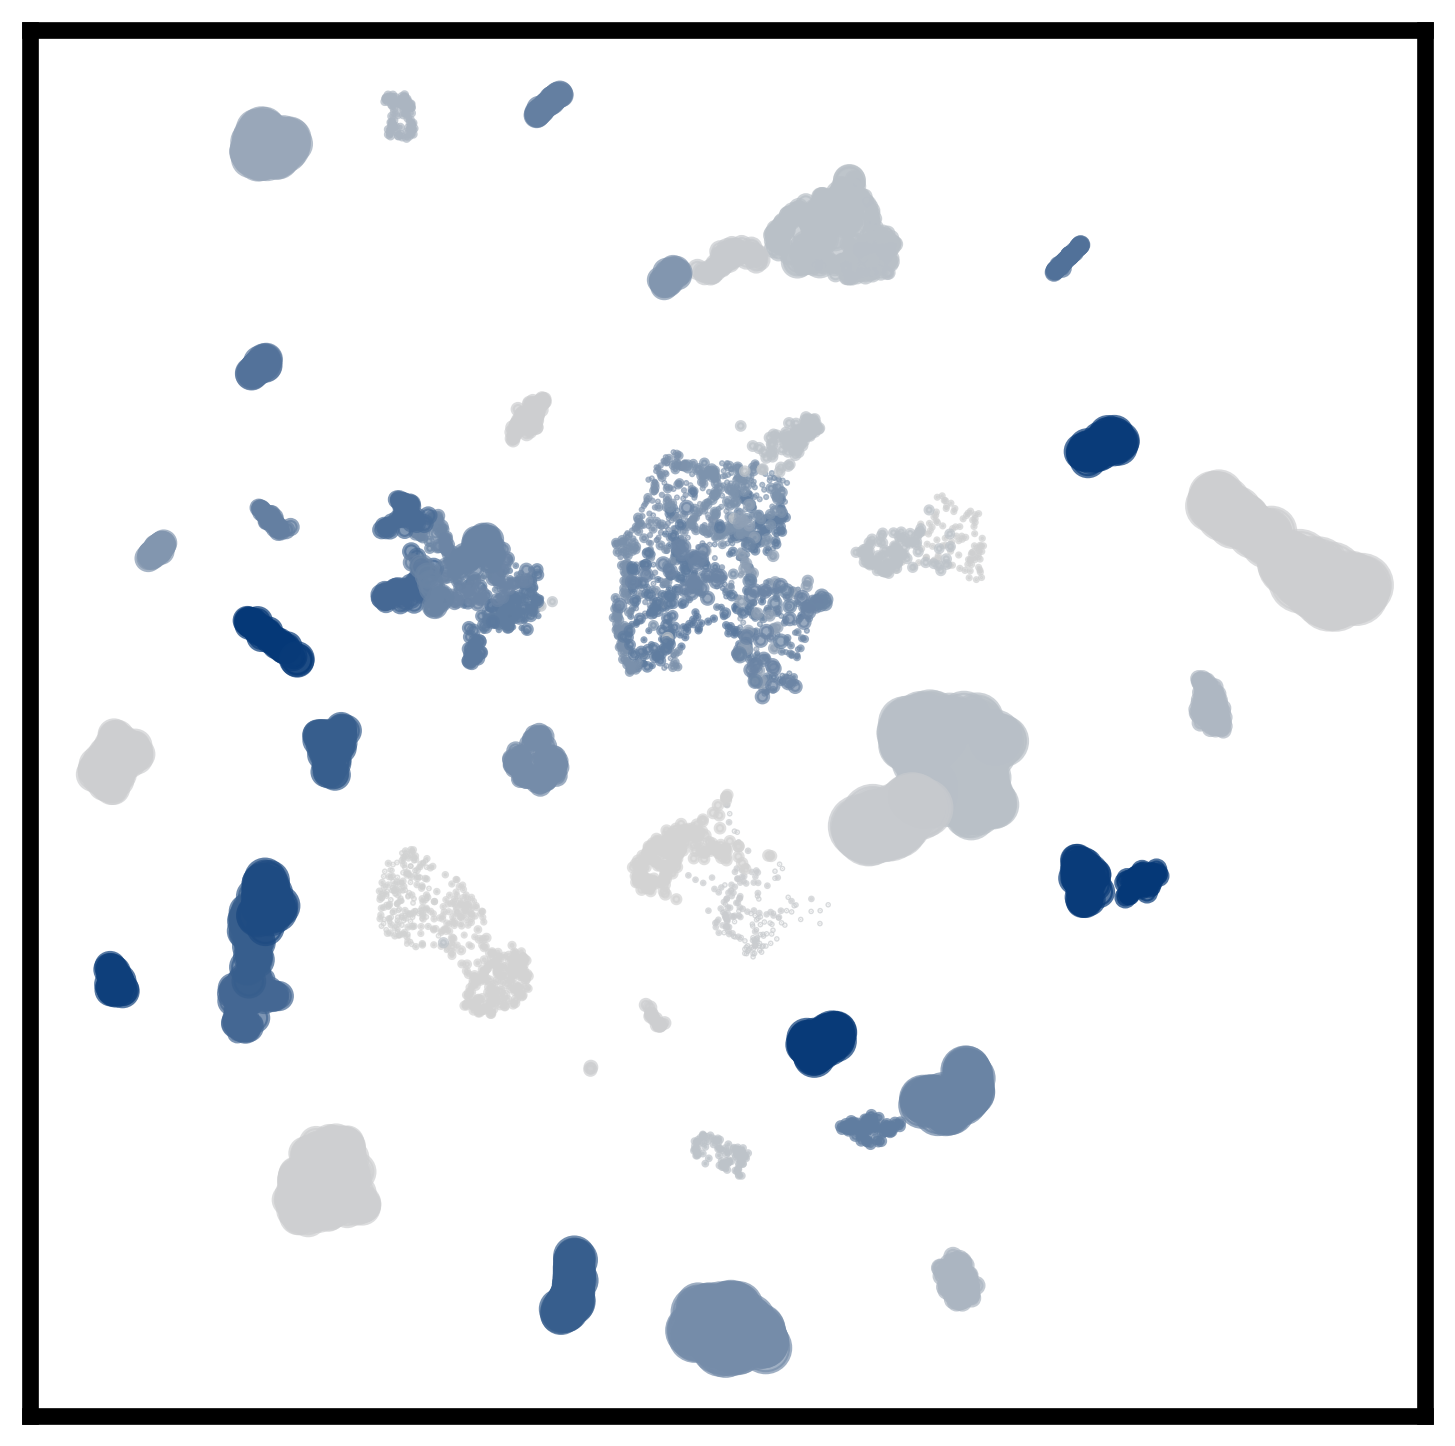

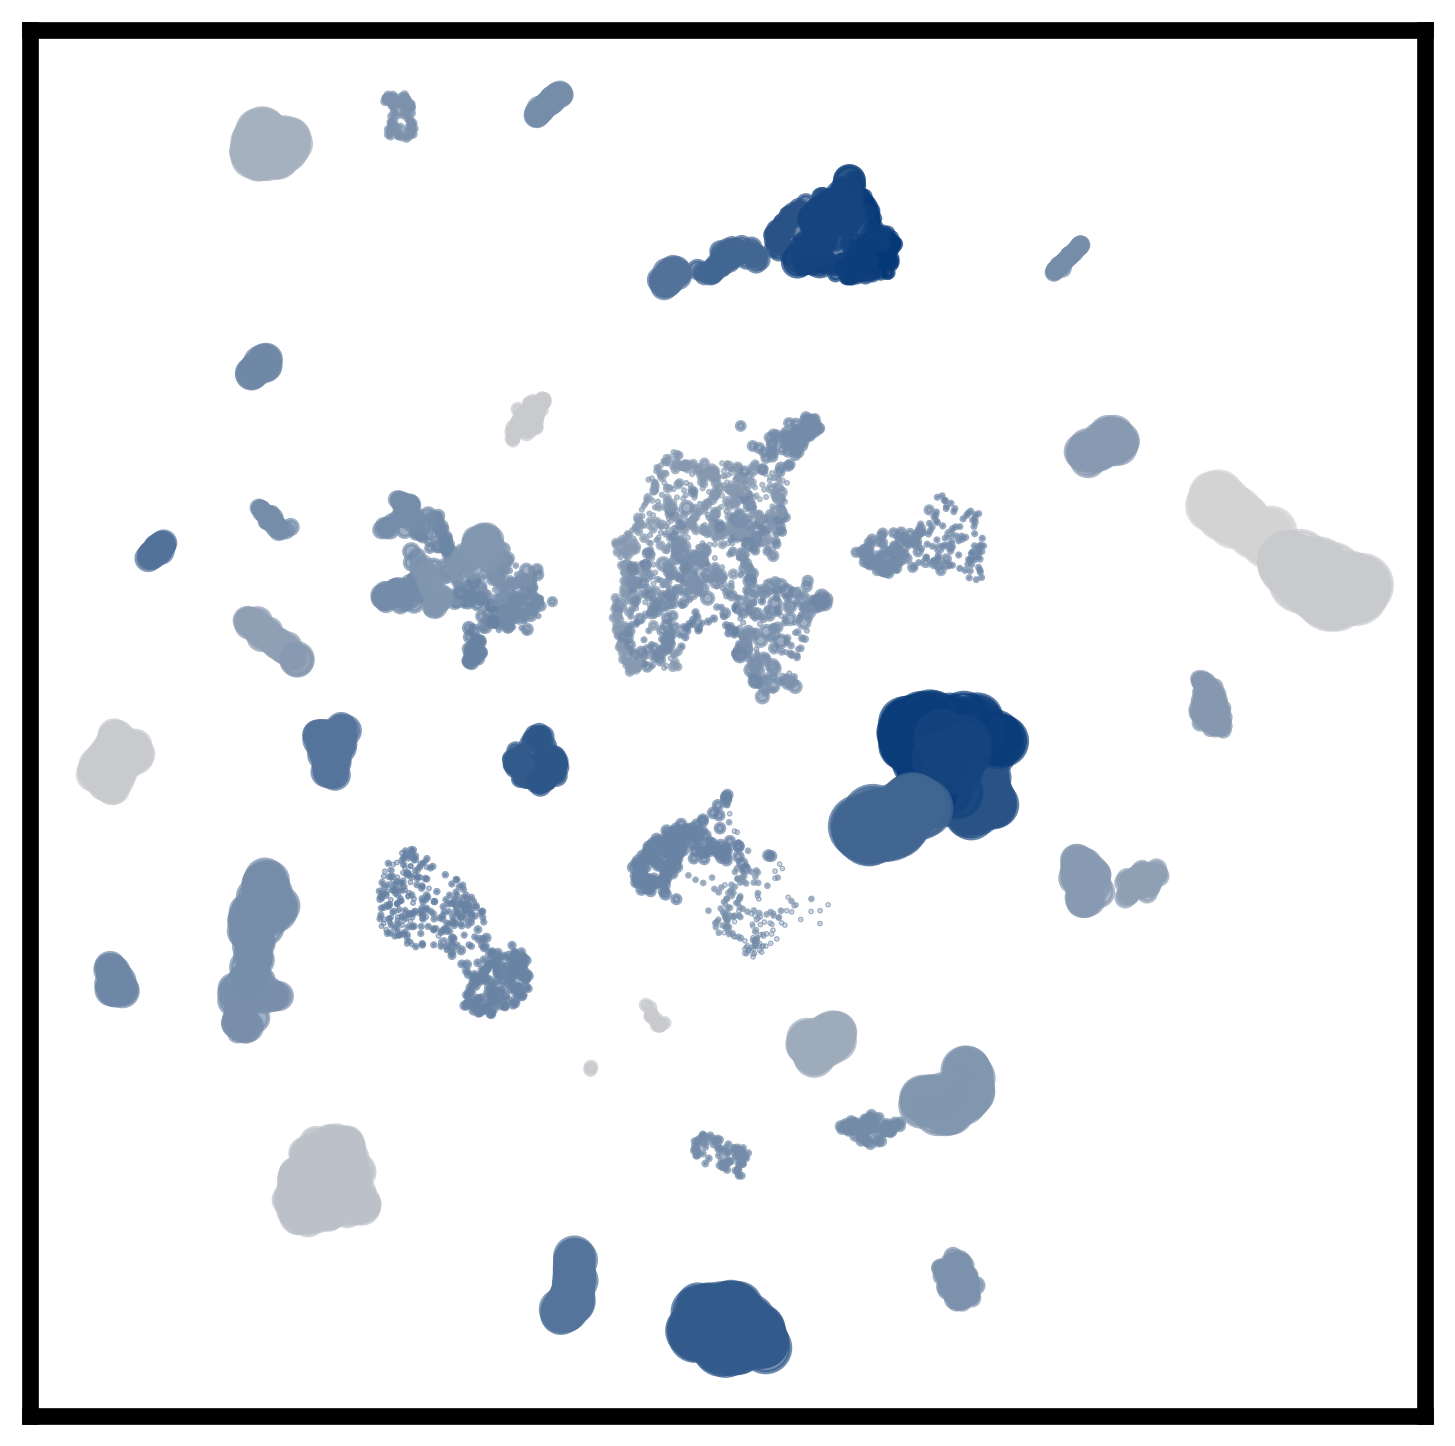

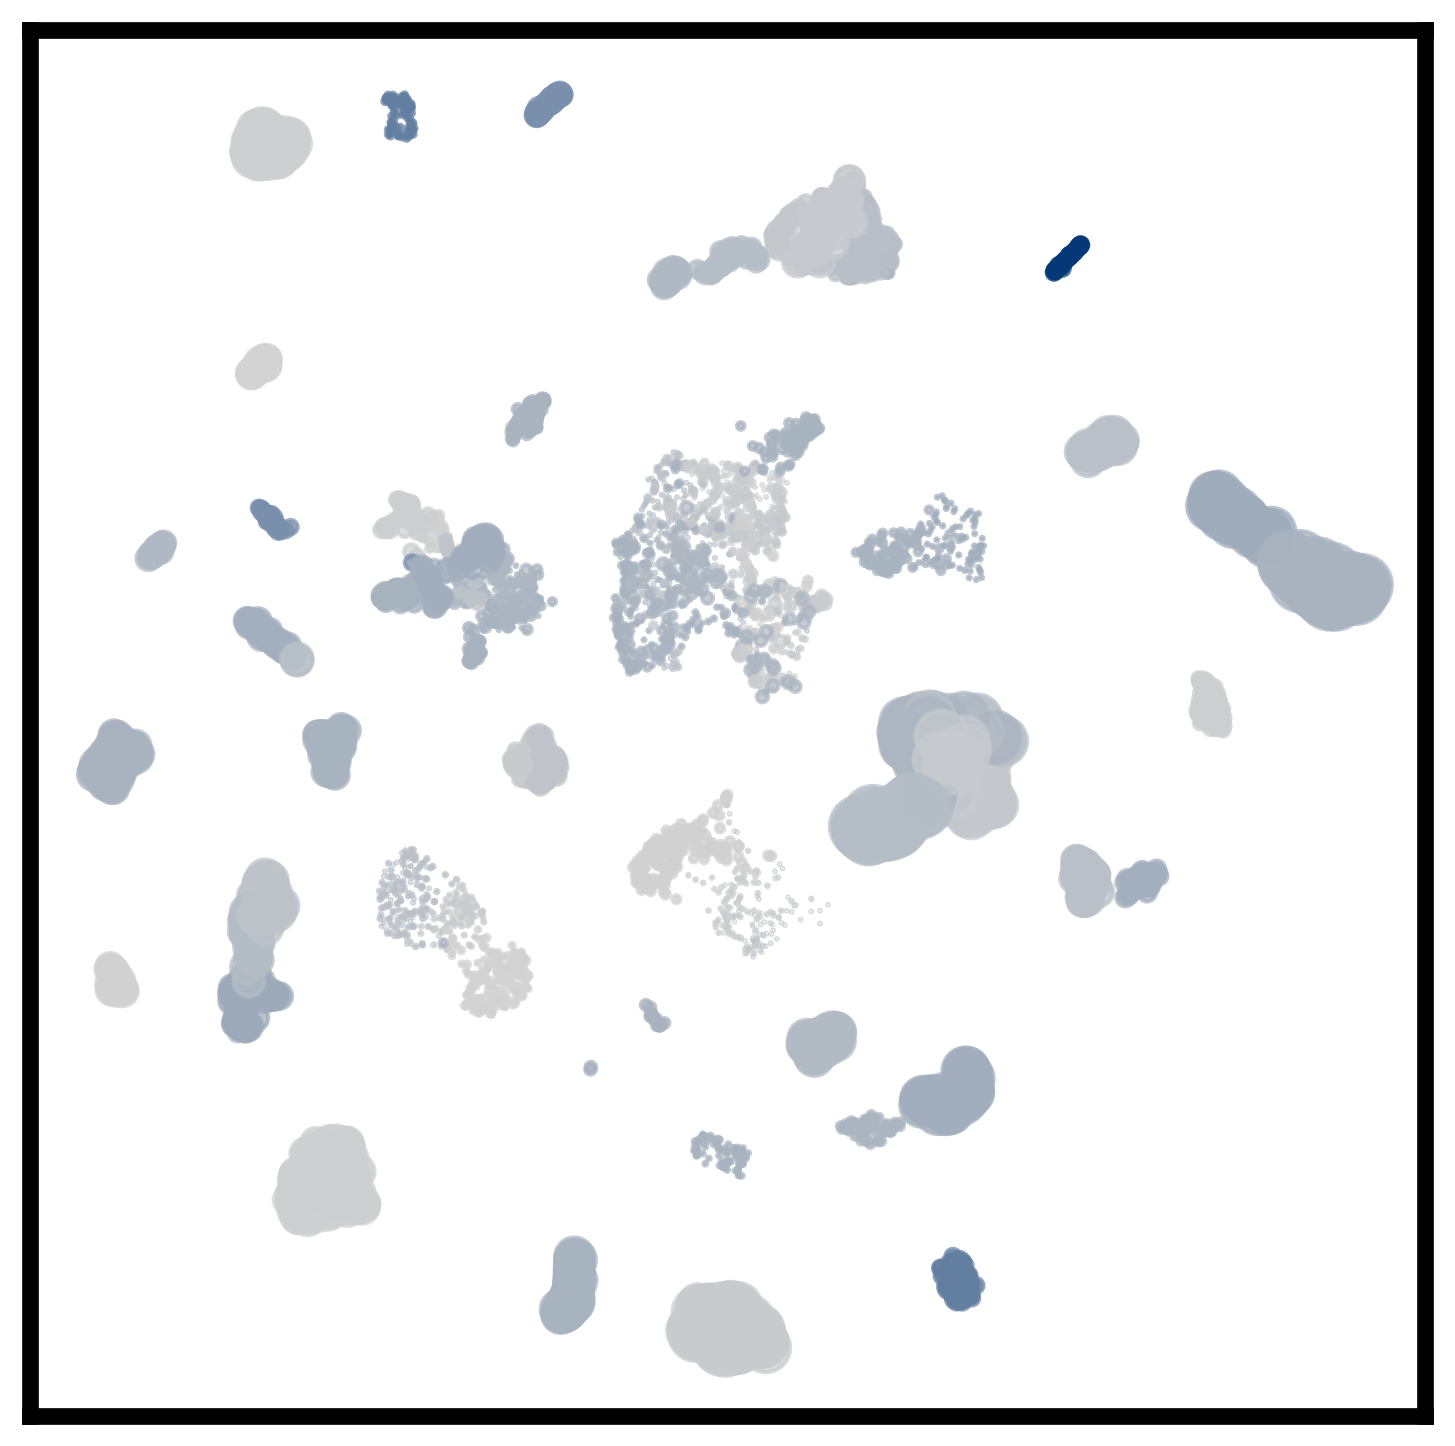

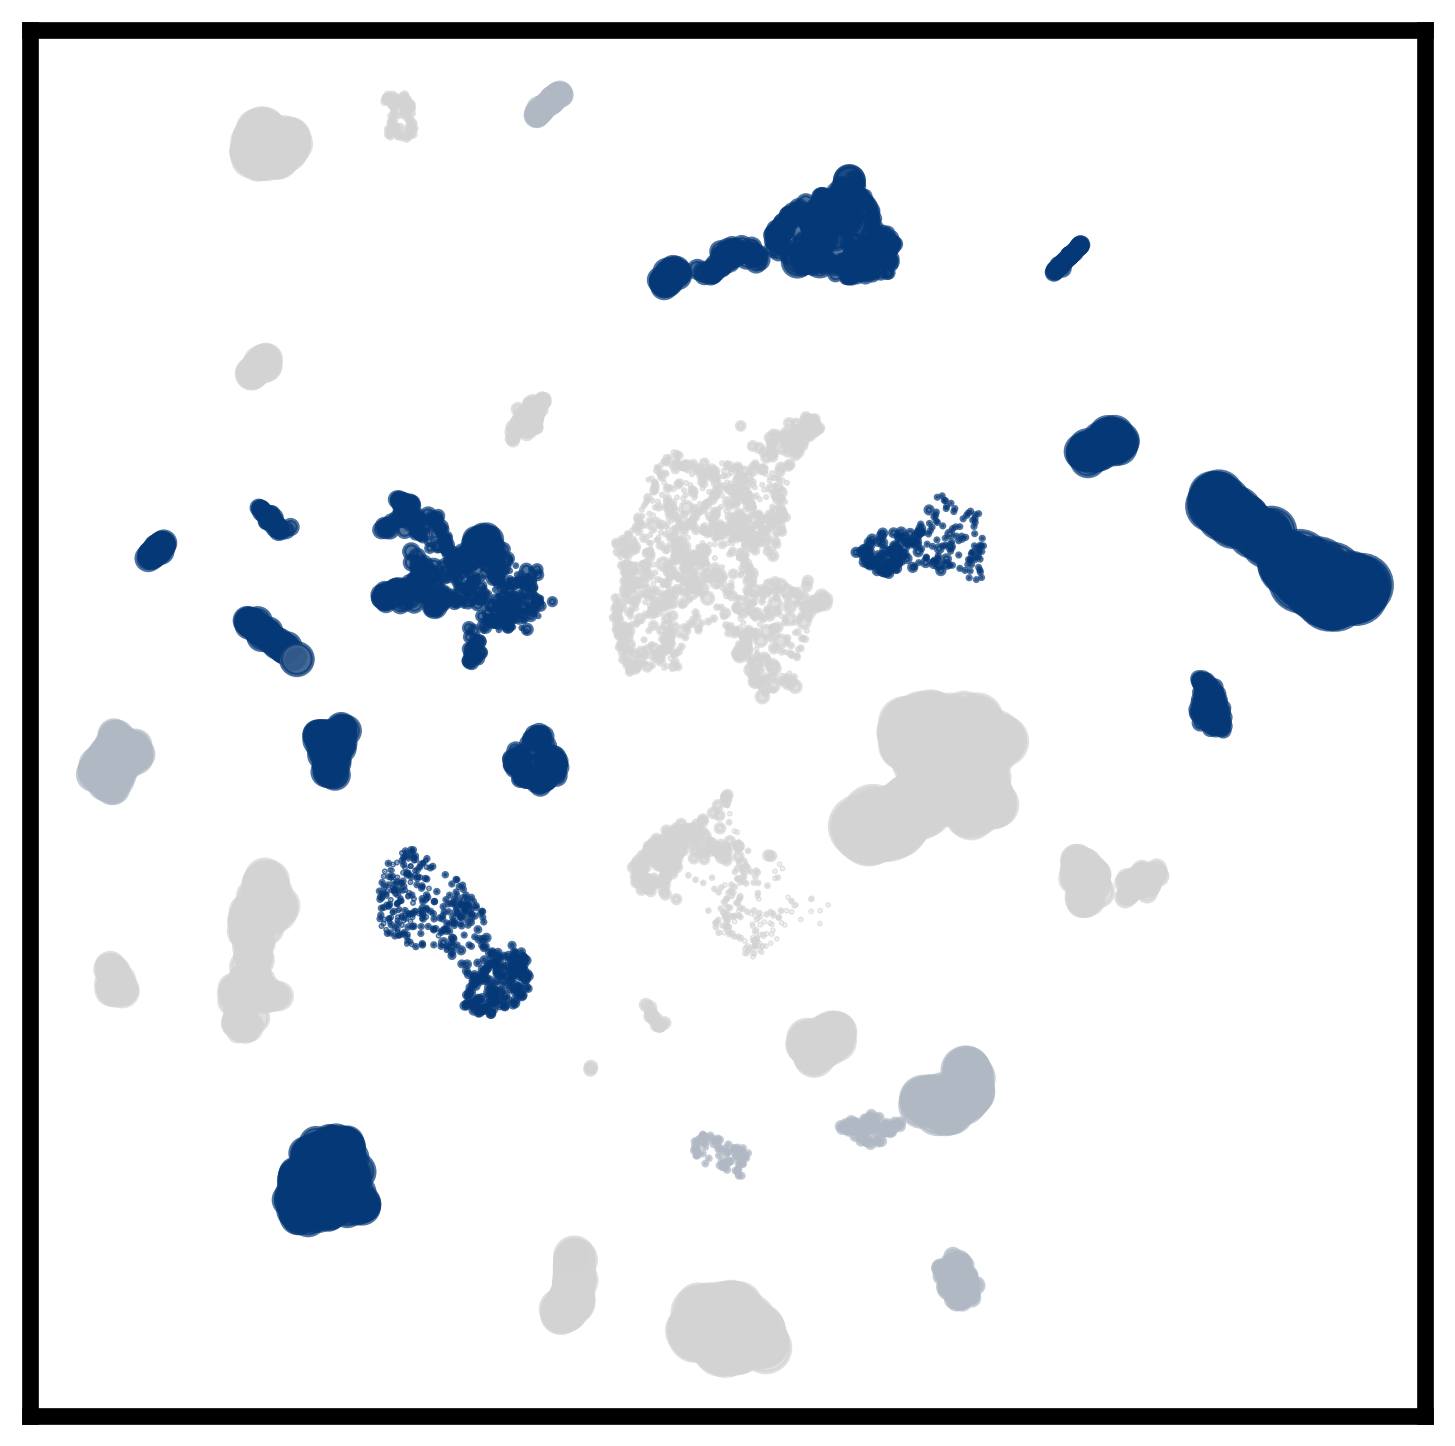

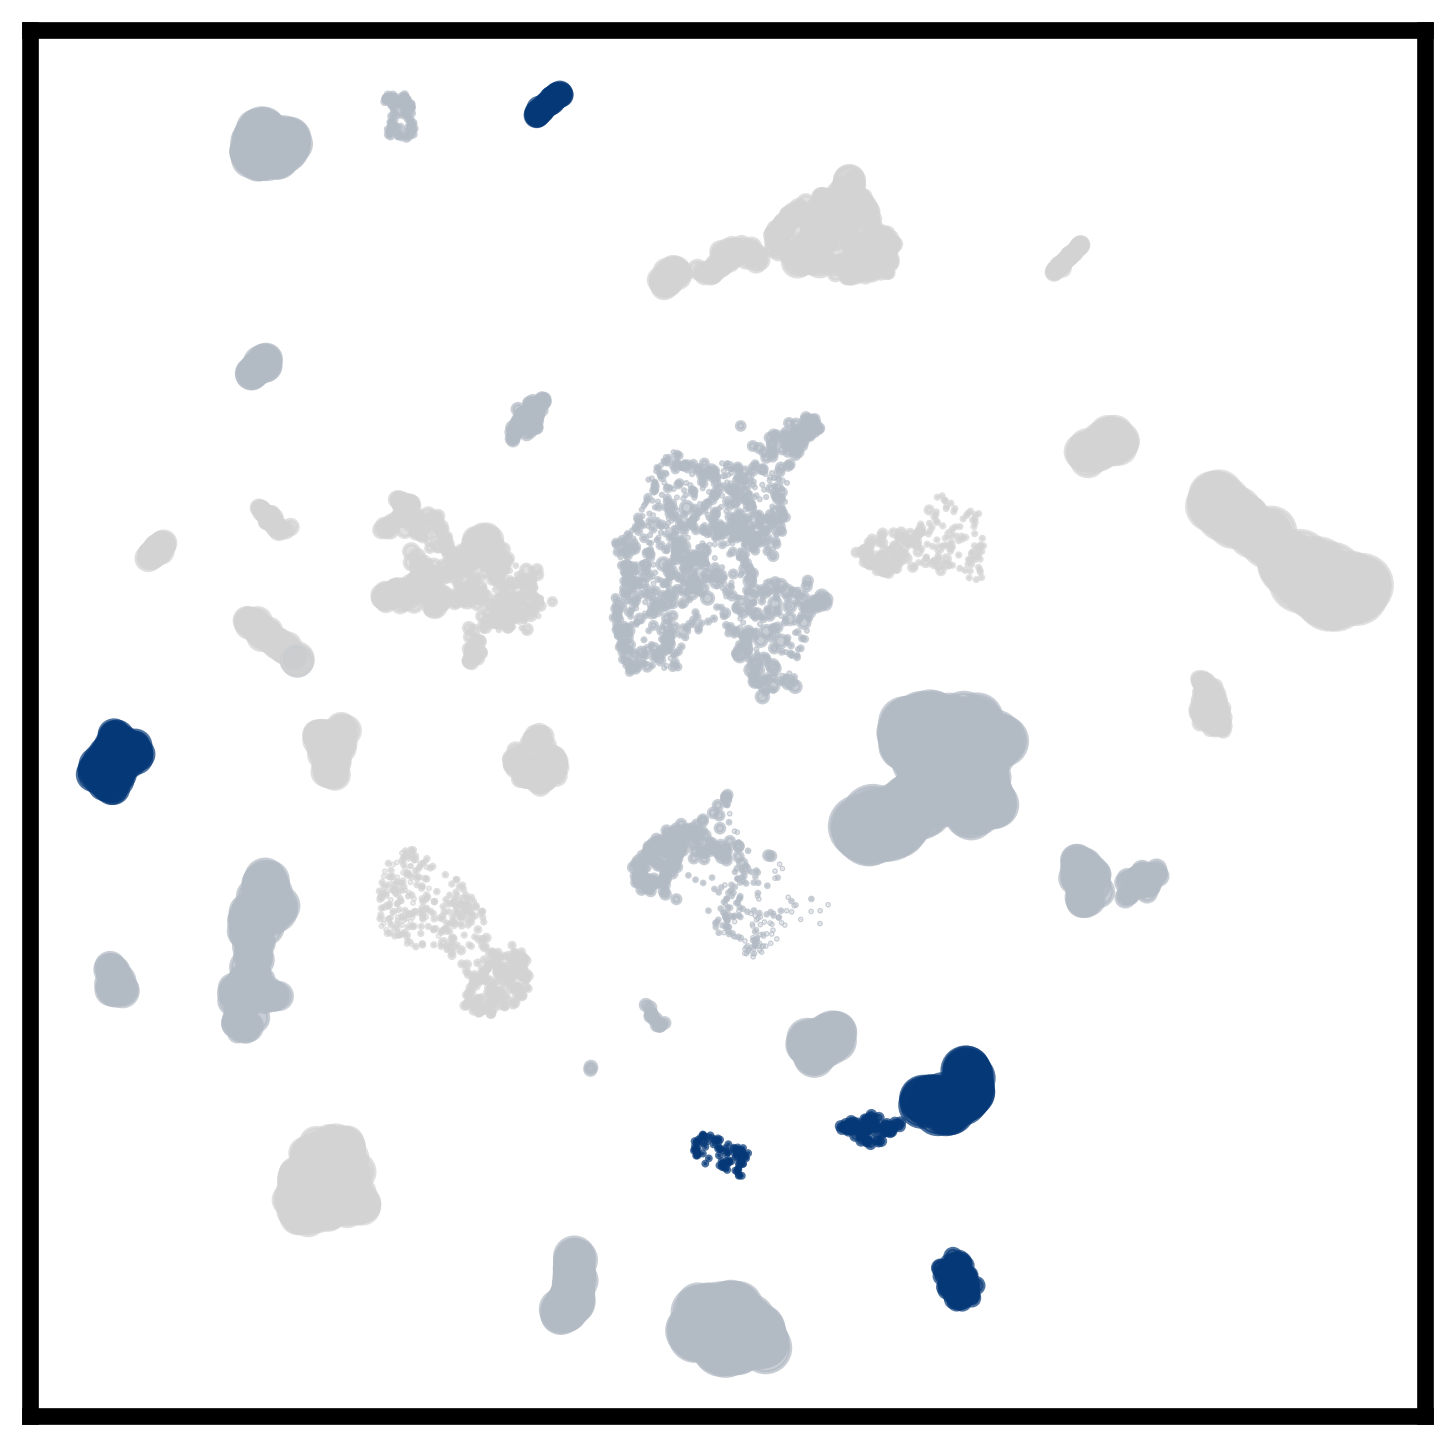

In [19]:
cvals = [0.0, 1.0] 
colors = ["#d3d3d3", "#053877"]

norm = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm, cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

for feature in feature_columns:
    plt.figure(figsize=(6, 6), dpi=300)


    df_sorted = full_df.sort_values(by=size_col, ascending=True)
    norm = Normalize(vmin=df_sorted[feature].min(), vmax=df_sorted[feature].max())
    
    scatter = plt.scatter(
        df_sorted[umap_x], 
        df_sorted[umap_y],
        c=df_sorted[feature],
        cmap=cmap,
        s=df_sorted[size_col] / 5,
        alpha=0.7,
        norm=norm
    )

    plt.gca().spines['left'].set_linewidth(4)
    plt.gca().spines['right'].set_linewidth(4) 
    plt.gca().spines['top'].set_linewidth(4)
    plt.gca().spines['bottom'].set_linewidth(4)
    
    #cbar = plt.colorbar(scatter, ax=plt.gca(), fraction=0.1, pad=0.01, ticks=[df_sorted[feature].min(), df_sorted[feature].max()])
    #cbar.ax.set_yticklabels(['Min.', 'Max.'], fontsize=45, font='Arial', fontweight='bold')
    #cbar.set_label(f'{feature} Values', fontsize=14, fontweight='bold')
    
    #plt.title(f'{feature}', fontsize=16, fontweight='bold')
    #plt.xlabel('UMAP Dimension 1', fontsize=16, fontweight='bold', font='Arial')
    #plt.ylabel('UMAP Dimension 2', fontsize=16, fontweight='bold', font='Arial')
    plt.xticks([])
    plt.yticks([])
    #plt.grid(True, linestyle='--', alpha=0.5)
    #plt.tight_layout()
    plt.show()
